# DS 2500 Day 16

Mar 14, 2023

#### Content:

- $R^2$ review
- extending our regression model
    - multiple regression
        - many different x features in our line, not just one:
        - trip_count = 4429.46 - 112.01 wind - 1678.75 rain + 125.38 temp_f
    - exponential
    - polynomial
    
#### Admin:
- Project
    - mentor
    - data & analysis plan due Mar 27 @ 11:59
        - format (& example)
        - submission (adding group members)
- Mar 28th class: choose your own adventure!
    - [vote on piazza](https://piazza.com/class/lbxsbawi9yq2f9/post/314)
        - vote before Mar 20th please
    

# On the last episode of DS2500 ....

By looking a set of observations $(x_j, y_j)$ we are able to build a model which estimates y from x as:

$$ \hat{y} = a_0 + a_1 x $$

The model isn't always perfect and our estimate, $\hat{y}_j$ isn't always equal to the exact $y_j$ which was observed:

$$\texttt{Error}_j = \hat{y}_j - y_j$$

We measure how well a model fits the observations based on the Mean of Squared Errors:

$$\texttt{MSE} = \frac{1}{N} \sum_j (\hat{y}_j - y_j)^2 $$

- Low values of MSE imply the model's line comes close to each observation
- High values of MSE imply the model's line is far from observations

We used `LinearRegression` from `sklearn.linear_model` to find the line, defined via parameters $a_0, a_1$, which minimizes the MSE:

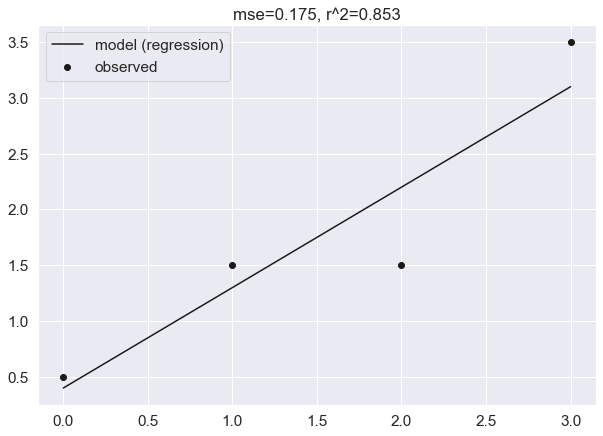

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sns.set(font_scale=1.4)

x = np.array([0, 1, 2, 3])
y_true = np.array([.5, 1.5, 1.5, 3.5])

# x must be 2 dimensional with shape: (n_samples, n_features)
x = x.reshape(-1, 1)

def plot_regression(x, y_true, color='k'):
    # fit and predict regression model
    reg = LinearRegression()
    reg.fit(x, y_true)
    y_pred = reg.predict(x)
    
    # compute mean squared error
    mse = ((y_pred - y_true) ** 2).mean()
    r2 = r2_score(y_true=y_true, y_pred=y_pred)

    # plot it
    plt.scatter(x, y_true, label='observed', color=color)
    plt.plot(x, y_pred, label='model (regression)', color=color)
    plt.gca().set_title(f'mse={mse:.3f}, r^2={r2:.3f}')
    plt.legend()
    
plot_regression(x, y_true)
plt.gcf().set_size_inches(10, 7)

# $R^2$ alternate motivation

- MSE is great to compare two models which attempt to fit the same y data 
- ... but there is a problem when I'm using it to evaluate models which fit different y data:

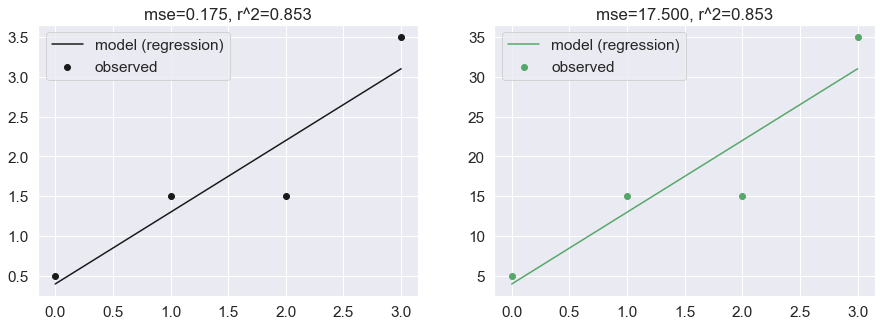

In [2]:
x = np.array([0, 1, 2, 3])

# NOTE: y_true of the second model has a larger scale than the first model
y_true = np.array([.5, 1.5, 1.5, 3.5])
y_true10 = 10 * y_true

# x must be 2 dimensional with shape: (n_samples, n_features)
x = x.reshape(-1, 1)

fig, ax = plt.subplots(1, 2)
plt.sca(ax[0])
plot_regression(x, y_true, color='k')

plt.sca(ax[1])
plot_regression(x, y_true * 10, color='g')
plt.gcf().set_size_inches(15, 5)

**MSE depends on the scale of y.  Different scales in y values will yield different MSE (even if models are similar)**

We need a way of measuring how well the model fits the observations which does not rely on the scale of y:

$$ R^2 = 1 - \frac{\texttt{MSE}}{\sigma_y^2} $$

$R^2$ is the percent of variance, in y, which is explained by the model.

Above, 85.3% of the movement of the observations in y can be explained by movements in x according to our model.

# Predicting y from a single feature x (review)

What is the total `trip_count` of blue bike rides in Boston given `temp`?

    trip_count = a_0 + a_1 * temp 

In [3]:
import pandas as pd

df = pd.read_csv('bluebike_201910.csv', index_col='date')
df.head()

,trip_count,temp_f,wind,rain
date,,,,
2019-10-01,12183,69,13,0
2019-10-02,9071,66,11,1
2019-10-03,11496,54,9,0
2019-10-04,11767,60,16,0
2019-10-05,9315,56,9,0


In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def disp_regress(df, x_feat_list, y_feat, verbose=True):
    """ linear regression, displays model w/ coef
    
    Args:
        df (pd.DataFrame): dataframe
        x_feat_list (list): list of all features in model
        y_feat (list): target feature
        verbose (bool): toggles command line output
        
    Returns:
        reg (LinearRegression): model fit to data
    """
    # initialize regression object
    reg = LinearRegression()

    # get target variable
    # (note: since we index with list -> garauanteed 2d x array, no reshape needed)
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)
    
    if verbose:
        # print model   
        model_str = y_feat + f' = {reg.intercept_:.2f}'
        for feat, coef in zip(x_feat_list, reg.coef_):
            s_sign = ' - ' if coef < 0 else ' + '
            model_str += s_sign + f'{np.abs(coef):.2f} {feat}'
        print(model_str)

        # compute / print r2
        r2 = r2_score(y_true=y, y_pred=y_pred)
        print(f'r2 = {r2:.5} (not cross validated)')
    
    return reg

In [5]:
df_bike = pd.read_csv('bluebike_201910.csv')

disp_regress(df=df_bike, x_feat_list=['rain'], y_feat='trip_count');

trip_count = 10644.35 - 2224.62 rain
r2 = 0.27119 (not cross validated)


In [6]:
disp_regress(df=df_bike, x_feat_list=['wind'], y_feat='trip_count');

trip_count = 11469.35 - 119.16 wind
r2 = 0.13701 (not cross validated)


# Multiple Regression (using more than one x to predict a single y)

How can we predict total bike rides using more than a single variable?

    trip_count = a_0 + a_1 * temp + a_2 * wind + a_3 * rain

Let's examine what `disp_regress()` is doing differently than our single variable regression previously studied:

```python
    # get target variable
    # (note: since we index with list -> garauanteed 2d x array, no reshape needed)
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)
```

In [7]:
disp_regress(df=df_bike, y_feat='trip_count', x_feat_list=['rain']);

trip_count = 10644.35 - 2224.62 rain
r2 = 0.27119 (not cross validated)


In [8]:
disp_regress(df=df_bike, y_feat='trip_count', x_feat_list=['wind', 'rain']);

trip_count = 11883.26 - 96.41 wind - 2034.86 rain
r2 = 0.35892 (not cross validated)


In [9]:
disp_regress(df=df_bike, y_feat='trip_count', x_feat_list=['wind', 'rain', 'temp_f']);

trip_count = 4429.46 - 112.01 wind - 1678.75 rain + 125.38 temp_f
r2 = 0.46388 (not cross validated)


each new feature (e.g. temp, rain) corresponds to a feature column in x
- x has shape (n_samples, n_features)

In [10]:
# indexing with a particular column yields 1d array
df_bike.loc[:, 'rain'].values.shape

(31,)

In [11]:
# indexing with a list of columns yields a 2d array (no need to reshape)
df_bike.loc[:, ['rain', 'temp_f']].values.shape

(31, 2)

We no longer need to `.reshape(-1, 1)` as was done in single feature case

## Adding more features to your regression model ...
- ... does not decrease $r^2$
    - at worst, if a feature isn't helpful, optimization can set its coefficient to zero so it has no impact
- ... may confuse the interpretation of your results
     - see examples below:

In [12]:
# add celsius & kelvin
df_bike['temp_c'] = (df_bike['temp_f'] - 32) / 1.8
df_bike['temp_k'] = df_bike['temp_c'] + 273

df_bike.head()

,date,trip_count,temp_f,wind,rain,temp_c,temp_k
0,2019-10-01,12183,69,13,0,20.555556,293.555556
1,2019-10-02,9071,66,11,1,18.888889,291.888889
2,2019-10-03,11496,54,9,0,12.222222,285.222222
3,2019-10-04,11767,60,16,0,15.555556,288.555556
4,2019-10-05,9315,56,9,0,13.333333,286.333333


In [13]:
disp_regress(df_bike, y_feat='trip_count', x_feat_list=['temp_f']);

trip_count = 1157.50 + 144.65 temp_f
r2 = 0.15049 (not cross validated)


In [14]:
disp_regress(df_bike, y_feat='trip_count', x_feat_list=['temp_f', 'wind', 'rain']);

trip_count = 4429.46 + 125.38 temp_f - 112.01 wind - 1678.75 rain
r2 = 0.46388 (not cross validated)


In [15]:
disp_regress(df_bike, y_feat='trip_count', x_feat_list=['temp_f']);

trip_count = 1157.50 + 144.65 temp_f
r2 = 0.15049 (not cross validated)


In [16]:
# changing scale of features doesn't help r2
disp_regress(df_bike, y_feat='trip_count', x_feat_list=['temp_k']);

trip_count = -65293.23 + 260.36 temp_k
r2 = 0.15049 (not cross validated)


In [17]:
disp_regress(df_bike, y_feat='trip_count', x_feat_list=['temp_c']);

trip_count = 5786.19 + 260.36 temp_c
r2 = 0.15049 (not cross validated)


In [18]:
disp_regress(df_bike, y_feat='trip_count', x_feat_list=['temp_c']);

trip_count = 5786.19 + 260.36 temp_c
r2 = 0.15049 (not cross validated)


In [19]:
# adding redundant features doesn't help r2
disp_regress(df_bike, y_feat='trip_count', x_feat_list=['temp_c', 'temp_c']);

trip_count = 5786.19 + 130.18 temp_c + 130.18 temp_c
r2 = 0.15049 (not cross validated)


### Interpretting Regression Coefficients is subtle:
1. variance of the x features impacts coefficients
    - `temp_c` and `temp_f` contain same information
        - `trip_count = 1157.50 + 144.65 temp_f`
        - `trip_count = 5786.19 + 260.36 temp_c`
1. features can "steal" each others influence, we can't understand any single coefficient out the conext of others:
    - `trip_count = 5786.19 + 260.36 temp_c`
    - `trip_count = 5786.19 + 130.18 temp_c + 130.18 temp_c`
    
Takeaways: 
1. don't interpret the magnitude of regression coefficient as its importance
    - use `RandomForestRegressor` intsead (see HW or lab)
1. "slopes" aren't as easily interpretted:
    - slope: "what happens to y when some x feature increases by 1 unit?" ...
        - assume all other features are held constant ...
        - ... but other features are often correlated, so its nonsensical to "hold constant"
            - what does it mean to increase temp by 1 deg celsius while holding temp (in fahrenheit) constant?
        - punchline: check for correlation in x features when interpretting "slopes", see what else changes

In [20]:
# (++) adding features which are "nearly" redundant yields some funny numerical issues
# temp_k is "almost" temp_c + 273 ... but due to float precision error there are tiny differences
disp_regress(df_bike, y_feat='trip_count', x_feat_list=['temp_c', 'temp_k']);

trip_count = 690475343465083776.00 + 2529213712326553.50 temp_c - 2529213712326293.50 temp_k
r2 = 0.15935 (not cross validated)


## In Class Assignment 1

1. Using the dataset of taxi cab rides, lets see how much progress we can make reverse-engineering the pricing structure into the form:

`total` = a_0 + a_1 * `distance` + a_2 * `tolls` + a_3 * `tip` + a_4 * `fare` + a_5 * `passengers`

so that one can predict the cost of future rides.

2. Are you sure that this formula is the same that the taxi uses?  Explain why or why not
    - synthesize your real world knowledge of cab rides with the results

3. (++) We expect `tip` and `tolls` to be passed directly onto customer (forcing their `a_i` coefficient to be exactly one above).  How can we build a model which accomplishes this while still optimizing the other coefficients?

In [21]:
df_taxi = sns.load_dataset('taxis')
df_taxi.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


In [22]:
#predicting the cost of rides
disp_regress(df=df_taxi, y_feat='total', x_feat_list = ['distance', 'tolls', 'tip', 'fare', 'passengers']
);

total = 3.10 - 0.01 distance + 1.02 tolls + 1.17 tip + 0.97 fare + 0.06 passengers
r2 = 0.99402 (not cross validated)


### Response:
Although this formula has a r^2 of 99.4%, it is not the ones that the taxi use. Taxis do not consider the number of passengers into the total cost nor give discounts for longer distances. In additional, there is no constant multiplier for tips. Passengers will give tips according to their own opinions.

# Choosing a different regression model
- linear regression
    - `y_pred = a_0 + a_1 * some_x_feat + a_2 some_other_x_feat + ... `
    - notice: there are multiple, different x features above
- polynomial regression
    - $\hat{y} = \alpha_0 + \alpha_1 x + \alpha_2 x^2 + \alpha_3 x^3$
    - notice: there is only 1 input x feature above
- exponential regression
    - $\hat{y} = \alpha_0 e^{a_1 x}$

# Exponential Regression 1

Suppose we want to fit a line to data whose y grows exponentially with x:

$$y = \alpha_0 e^{a_1 x}$$

## Fitting a straight line doesn't really work well...

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

sns.set(font_scale=1.4)

def get_exp_data(alpha0, a1, n=30, x=None, noise_var=1):
    """ builds x, y with noisy exponential relationship
    
    y = \alpha_0 e^{a_1 x}
    
    Args:
        alpha0 (float): model param (see above)
        a1 (float): model param (see above)
        n (int): number of samples (default 0 to 1)
        x (np.array): domain to sample
        noise_var (float): variance of noise
        
    Returns:
        x (np.array): input features
        y (np.array): output features
    """
    
    if x is None:
        x = np.linspace(0, 1, n)
        
    # we explicitly build y with the given relationship
    y = alpha0 * np.exp(a1 * x)

    # its unfair to assume that all points fall on this line, in practice
    # our data will be "messy".  we can approximate this by adding noise
    # to the y computed directly above
    np.random.seed(0)
    y = y + np.random.standard_normal(n) * noise_var
    
    # reshape x to sklearn standard (many samples, one feature)
    x = x.reshape(-1, 1)
    
    return x, y

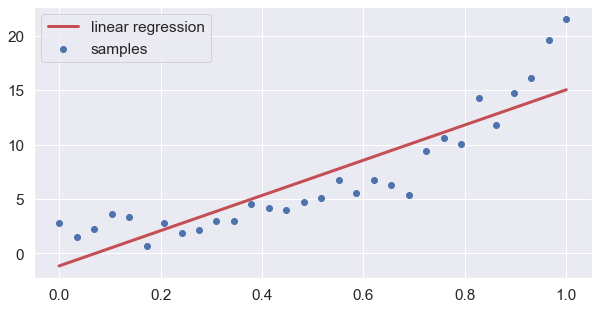

In [24]:
# get exp scatter points
x, y = get_exp_data(alpha0=1, a1=3)

# scatter
plt.scatter(x, y, label='samples')

# build / fit linear model
reg = LinearRegression()

# plot linear model
reg.fit(x, y)
y_hat = reg.predict(x)
plt.plot(x, y_hat, linewidth=3, color='r', label='linear regression')

plt.legend()
plt.gcf().set_size_inches(10, 5)

# Exponential Regression 2

Instead of fitting our observations $(x_j, y_j)$ with the typical linear model:

$$\hat{y} =  a_0 + a_1 x $$

What if we take the log of each $y_j$ first so that we fit $(x_j, \log y_j)$ instead?

$$\hat{\log{y}} =  a_0 + a_1 x $$

Text(0.5, 1.0, 'great linear fit :)')

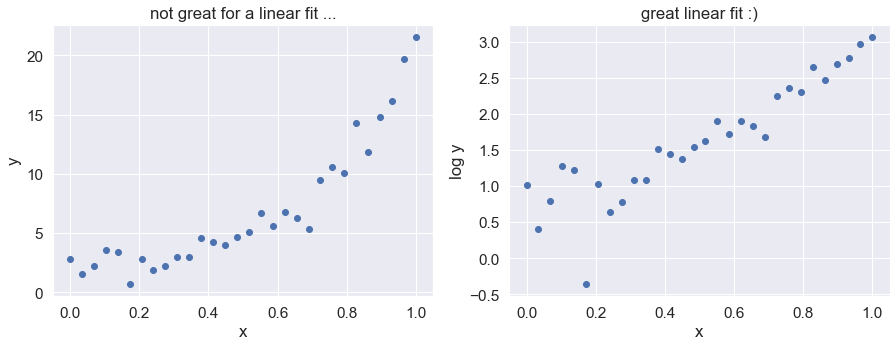

In [25]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

plt.sca(axs[0])
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
axs[0].set_title('not great for a linear fit ...')

plt.sca(axs[1])
plt.scatter(x, np.log(y))
plt.xlabel('x')
plt.ylabel('log y')
axs[1].set_title('great linear fit :)')

## Exponential Regression 3

Algebraically, whats going on here?

$$ \begin{align*}
\log \hat{y} &= a_0 + a_1 x
\\
e^{\log \hat{y}} &= e^{a_0 + a_1 x}
\\
\hat{y} &= \alpha_0 e^{a_1 x}
\end{align*}$$
where $\alpha_0 = e^{a_0}$.  

**By modelling log y instead of y directly, we are able to ensure that our "linear" regression gives us an exponential model**

(... if you think this is cool, just wait until we fit polynomials!)

## Expoential Regression: Approach 

- the input y (for training) to the regression must be log y:
    - apply `np.log()` to y before training
- the output of the regression is log y
    - apply `np.exp()` to get y so it is comparable with initial data

<img src="https://i.ibb.co/PrfJQnk/exp-to-linear.png" width=500px>

## Exponential Regression 4: Implementation


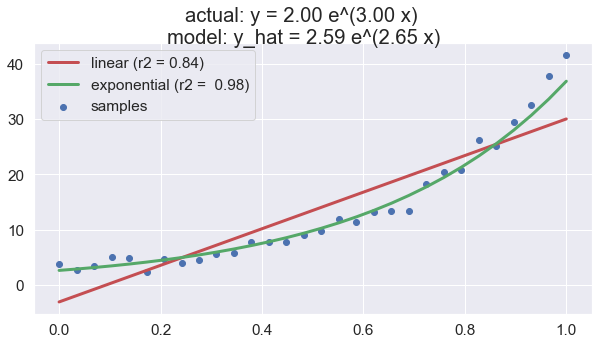

In [26]:
from sklearn.metrics import r2_score

# get exp scatter points
alpha0=2
a1=3
x, y = get_exp_data(alpha0=alpha0, a1=a1)

# scatter
plt.scatter(x, y, label='samples')

# build / fit linear model
reg = LinearRegression()

# plot linear model
reg.fit(x, y)
y_hat = reg.predict(x)
r2_linear = r2_score(y_true=y, y_pred=y_hat)
plt.plot(x, y_hat, linewidth=3, color='r', label=f'linear (r2 = {r2_linear:.2f})')

##############################################
############ pay attention below #############
##############################################

# plot exp model
reg.fit(x, np.log(y))            # NOTE: np.log applied (see previous approach slide)
y_hat = np.exp(reg.predict(x))   # NOTE: np.exp applied (see previous approach slide)

##############################################################
##############################################################

r2_exp = r2_score(y_true=y, y_pred=y_hat)
plt.plot(x, y_hat, linewidth=3, color='g', label=f'exponential (r2 = {r2_exp: .2f})')

# extract coefficients and print meaning
a_0_pred = reg.intercept_
a_1_pred = reg.coef_[0]


########## ok, one little coefficient modification too ##########
alpha0_pred = np.exp(a_0_pred)
#################################################################

title = f'actual: y = {alpha0:.2f} e^({a1:.2f} x) \n' + \
        f'model: y_hat = {alpha0_pred:.2f} e^({a_1_pred:.2f} x)'
        
plt.legend()
plt.suptitle(title)
plt.gcf().set_size_inches(10, 5)

# When to reach for an exponential model:

The "Math" definition of exponential: 
- growth in proportion to how much currently exists

Examples:
- population
    - animals
    - bacteria
    - covid cases
    - cancer cells
    - weeds in garden
    - fire
- anything growing at an interest rate
    - investments
    - debt

# In Class Assignment 2

For the `first_month_covid_us.csv` dataset
1. scatter `day` & `total_cases`
    - between February 22 and March 22, 2020 (whole csv)
1. fit an exponential model to the data
1. compute / print a (not cross validated) r2 value of the exponential model
1. (extra) print a string which shows the model itself


$$ \hat{y} = \alpha_0 e^{a_1 x} $$

In [27]:
df_covid = pd.read_csv('first_month_covid_us.csv', index_col='date')

df_covid.head()

,day,total_cases
date,,
2020-02-22,0,7.0
2020-02-23,1,8.0
2020-02-24,2,9.0
2020-02-25,3,10.0
2020-02-26,4,12.0


In [28]:
x_feat = 'day'
y_feat = 'total_cases'

x = df_covid.loc[:, x_feat].values
y = df_covid.loc[:, y_feat].values

# reshape
x = x.reshape(-1,1)

# initialize linear regression
reg = LinearRegression()

# fit & predict
reg.fit(x, np.log(y))
y_hat = np.exp(reg.predict(x))

# compute r2
r2 = r2_score(y_true = y, y_pred = y_hat)

# extract coefficient
a_0 = reg.intercept_
a_1 = reg.coef_[0]
alpha0 = np.exp(a_0)

print('r2 =', r2)

r2 = 0.9053514782592941


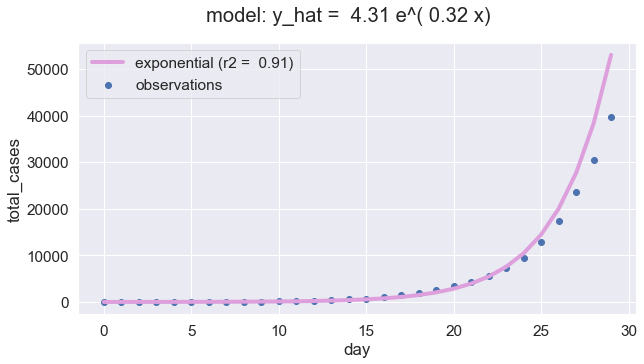

In [29]:
# plot
title = f'model: y_hat = {alpha0: .2f} e^({a_1: .2f} x)'
plt.scatter(x, y, label='observations')
plt.plot(x, y_hat, linewidth=4, color='plum', label = f'exponential (r2 = {r2: .2f})')
plt.xlabel(x_feat)
plt.ylabel(y_feat)
plt.legend()
plt.suptitle(title)
plt.gcf().set_size_inches(10,5)
            

# What if we don't want a straight line model?
- ~exponential regression~
- polynomial regression

# Polynomial Regression
We want to find another insight which allows us to perform polynomial regression just as we have done with exponential regression. 

**Polynomial Regression Model:**
$$
y = a_0\cdot x^0 + a_1\cdot x^1 + a_2 \cdot x^2 + ... + a_n \cdot x^n
$$

Before we can approach this problem, lets 
- study a clean representation of a polynomial
    - `coef_to_poly_str()`
- study a clean way of computing a polynomial
    - `poly()`
- build a good test case of data which comes from some known polynomial 
    - `get_poly_data()`

## Representing a Polynomial

In [30]:
def coef_to_poly_str(coef, include_zero=False):
    """ creates a str of polynomial corresponding to coef    

    Args:
        coef (np.array): coefficients of polynomial
        
    Returns:
        poly_str (str): str of polynomial
    """
    
    str_monomial_list = []
    for deg, coef in enumerate(coef):
        if coef == 0 and include_zero == False:
            # this coefficient is zero, just skip it altogether
            continue
            
        str_monomial_list.append(f'{coef:+.1f} x^{deg:d}')
        
    return 'y = ' + ' '.join(str_monomial_list)

In [31]:
coef_to_poly_str(coef=[123, 0, 0, 0, 99], include_zero=True)

'y = +123.0 x^0 +0.0 x^1 +0.0 x^2 +0.0 x^3 +99.0 x^4'

## Computing a Polynomial

In [32]:
def poly(x, coef):
    """ computes polynomials in x
    
    to represent the polynomial:
    
    a_0 x^0 + a_1 x^1 + a_2 x^2 + a_3 x^3 + ...
    
    coef = [a_0, a_1, a_2, a_3, ...]
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
        
    Returns:
        y (np.array): polynomial evaluated at every x
    """
    # initialize y as array of zeros
    y = np.zeros_like(x)
    
    # adds each monomial one at a time
    for deg, a in enumerate(coef):
        y += a * x ** deg
        
    return y 

Text(0.5, 0.98, 'y = +1.0 x^2')

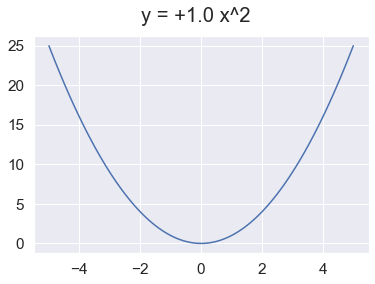

In [33]:
# validate that this works, lets build the polynomial x^2
# x^2 = 0 x^0 + 0 x^1 + 1 x^2 so coef = [0, 0, 1]
x = np.linspace(-5, 5, 101)
coef = np.array([0, 0, 1])
y = poly(x, coef)

# plot a polynomial
plt.plot(x, y)

# add title
poly_str = coef_to_poly_str(coef)
plt.suptitle(poly_str)

Text(0.5, 0.98, 'y = +10.0 x^1 -10.0 x^2 +1.0 x^3')

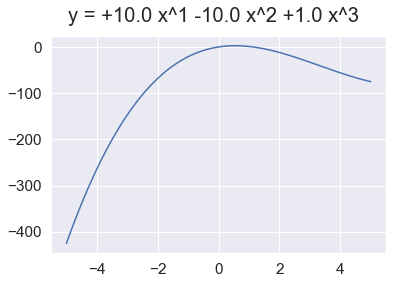

In [34]:
# lets play with a more interesting polynomial
coef = [0, 10, -10, 1]
y = poly(x, coef)

# plot a polynomial
plt.plot(x, y)

# add title
poly_str = coef_to_poly_str(coef)
plt.suptitle(poly_str)

# Building Polynomial Data

1. Build data from a polynomial
1. Add a bit of noise to y observations
    - data shouldn't be a perfect fit ... this isn't expected in practice

In [35]:
def get_poly_data(coef, x, std_dev=20):
    """ computes noisy data from a polynomial
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
        noise (float): std deviation of noise
        
    Returns:
        x (np.array): input values (gauranteed 2d array)
        y (np.array): noisy poly data
    """
    np.random.seed(0)
    y = poly(x, coef) 
    
    # add some noise
    y = y + np.random.standard_normal(x.size) * std_dev
    
    # reshape into sklearn standard (n_samples, n_features)
    x = x.reshape(-1, 1)
    return x, y

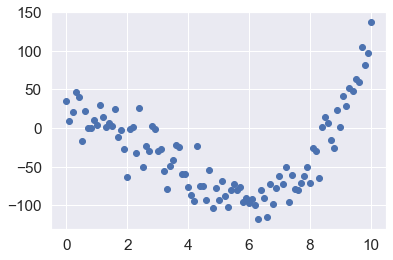

In [36]:
# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3
coef = [0, 10, -10, 1]

x = np.linspace(0, 10, 101)
x, y = get_poly_data(coef, x=x)
plt.scatter(x, y)

# Polynomial Regression: Approach

#### Polynomial Regression Model:
$$
y = a_0\cdot x^0 + a_1\cdot x^1 + a_2 \cdot x^2 + ... + a_n \cdot x^n
$$

where $x$ refers to the same input feature each time raised to a different power.

#### Multiple Regression Model:
$$
y = a_0\cdot x_0 + a_1 \cdot x_1 + a_2 \cdot x_2 + ... + a_n \cdot x_n
$$

where $x_i$ refer to distinct features.

## "tricking" model into looking at polynomial regression as multiple regression:

What if we "trick" sklearn's Linear Regression into thinking that higher order terms are new features.  That is, we'll set the "new" feature 
- $x_0$ as our single feature x raised the 0th power (always one)
- $x_1$ as our single feature x raised the 1st power
- $x_2$ as our single feature x raised the 2nd power
- $x_3$ as our single feature x raised the 3rd power

In [37]:
from sklearn.preprocessing import PolynomialFeatures

x = np.linspace(0, 10, 101)
x = x.reshape(-1, 1)

In [38]:
# examine "raw" features
x[18: 23]

array([[1.8],
       [1.9],
       [2. ],
       [2.1],
       [2.2]])

In [39]:
degree = 3
poly_feat = PolynomialFeatures(degree=degree)
x_poly = poly_feat.fit_transform(x)

# examine polynomial features
x_poly[18:23]

array([[ 1.   ,  1.8  ,  3.24 ,  5.832],
       [ 1.   ,  1.9  ,  3.61 ,  6.859],
       [ 1.   ,  2.   ,  4.   ,  8.   ],
       [ 1.   ,  2.1  ,  4.41 ,  9.261],
       [ 1.   ,  2.2  ,  4.84 , 10.648]])

# Note: There is no "intercept" in the Multiple Regression Model as before
- Previously our model was of the form `y = a_0 + a_1 x`
    - `a_0` is the intercept, which is unrelated to any input feature
- Currently, our model is of the form `y = a_0 x**0 + a_1 * x^**1 + a_2 * x ** 2`
    - `a_0` is the coefficient associated with the first x feature (always one)
    
    
By setting `LinearRegression(fit_intercept=False)` we tell `LinearRegression` to not add a new intercept `a_0`, it is no longer necessary given how we're building our polynomial regression.

## Polynomial Regression: Putting it all together

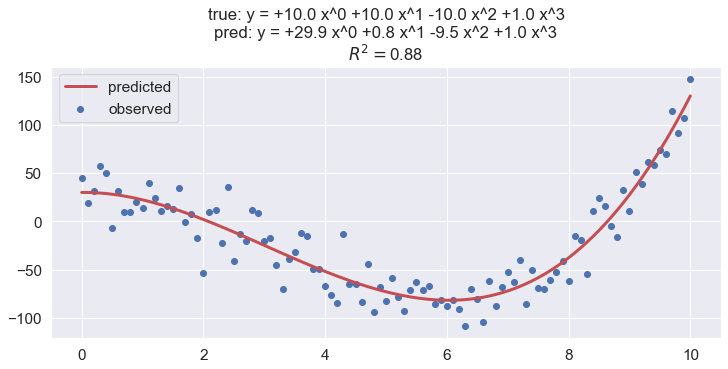

In [40]:
# y = 0 x^0 + 10 x^1 - 10 x^2 + 1 x^3
coef = [10, 10, -10, 1]

# in practice, we can't use the "right" answer (coef above)
# we'll revisit this later.  for now, we'll "cheat" by setting
# degree by peeking at proper answer
degree = len(coef) - 1

# get noisy polynomial data
x = np.linspace(0, 10, 101)
x, y = get_poly_data(coef, x=x)

########################################################
########################################################
########################################################
# process x to polynomial features
poly_feat = PolynomialFeatures(degree=degree)
x_poly = poly_feat.fit_transform(x)
########################################################
########################################################
########################################################

# fit polynomial regression
reg = LinearRegression(fit_intercept=False)
reg.fit(x_poly, y)

# predict y (from regression)
y_pred = reg.predict(x_poly)

# plot
plt.scatter(x, y, label='observed')
plt.plot(x, y_pred, color='r', linewidth=3, label='predicted')

# collect coefficients
coef_pred = reg.coef_

# getting strs of polynomial (to print)
str_poly_true = coef_to_poly_str(coef)
str_poly_pred = coef_to_poly_str(coef_pred)

plt.title(f'true: {str_poly_true}\npred: {str_poly_pred}\n$R^2=${r2_score(y, y_pred):.2f}')

plt.legend()
plt.gcf().set_size_inches(12, 5)

# ICA 3
Using the x and y data generated below:

1. Write a function `fit_plot_poly(x, y, degree)`:
    - projects raw x in to polynomial features of some `degree`
    - fits a polynomial regression model
    - plots the result
        - add degree of model in title
        
1. Loop over your `fit_plot_poly()` function to fit polynomials of degree 0, 1, 2, 3, ... 10 and respond to the questions below:
    - what do you notice about r^2 as the degree of the polynomial increases
    - is the polynomial with the lowest r^2 the best model (hint: no).  Why not?
        - (++) for a more compelling example, try reducing the number of observations to 11 ...
            - its tough to see the behavior of the polynomial between the 11 observatoins (should look piecewise linear).  try making and predicting a finer grained x in your `fit_plot_poly()` which allows you to observe the polynomial's behavior
   

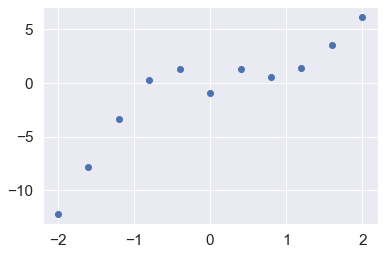

In [41]:
# initialize a polynomial and its domain
coef = np.array([0, 1, -1, 1])
x = np.linspace(-2, 2, 11)
x, y = get_poly_data(coef=coef, x=x, std_dev=1)
plt.scatter(x, y)

In [42]:
def fit_plot_poly(x, y, degree):
    """ dits and plots a polynomial of given degree
    
    Args:
        x (np.array): (n_samples, 1) array of x inputs
        y (np.array): (n_sample, 1) array of target values
        degree (int): max degree of polynomial
    """
    
    # project x
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)
    
    # fit via linear regression
    reg = LinearRegression(fit_intercept=False)
    reg.fit(x_poly, y)
    
    # predict y
    x_fine = np.linspace(x.min(), x.max(), 101).reshape(-1,1)
    x_fine_poly = poly.fit_transform(x_fine)
    y_pred_fine = reg.predict(x_fine_poly)
    
    
    # compute r2
    y_pred = reg.predict(x_poly)
    r2 = r2_score(y_true = y, y_pred = y_pred)
    
    # plot
    plt.plot(x_fine, y_pred_fine, label=f'no scross val r2={r2: .3f}', 
             color='r', linewidth=3)
    plt.scatter(x, y, label=f'observed', color='k')
    plt.legend()

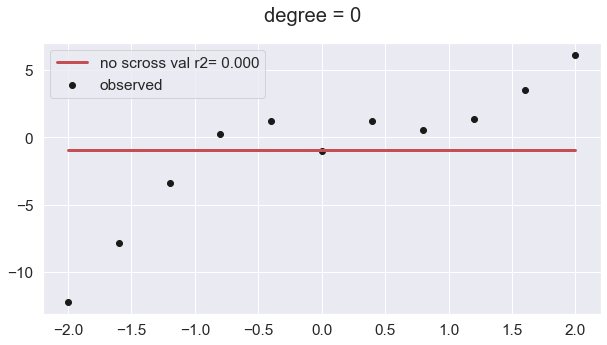

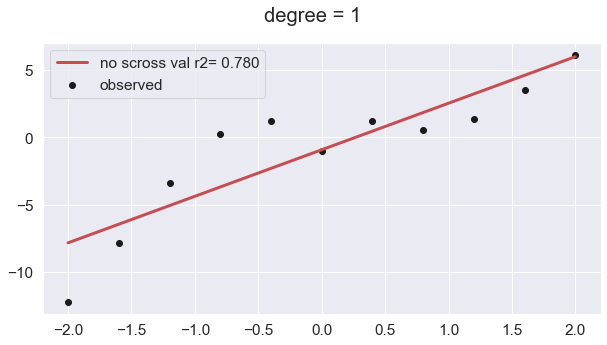

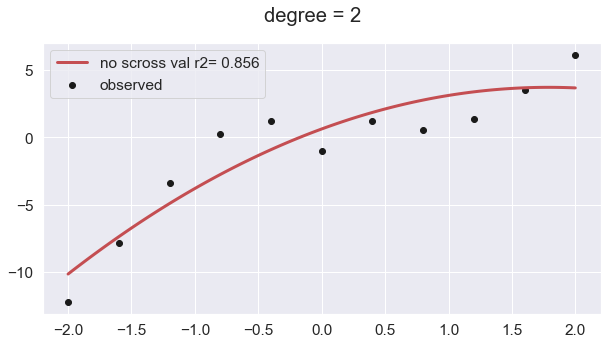

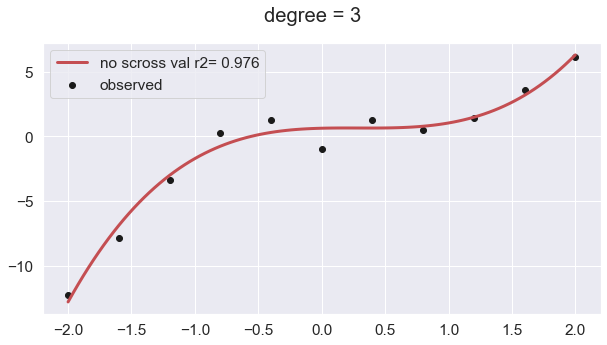

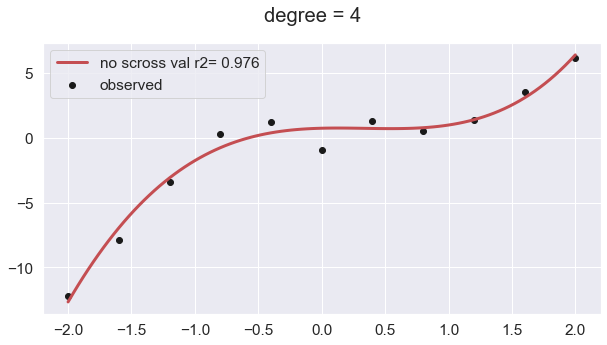

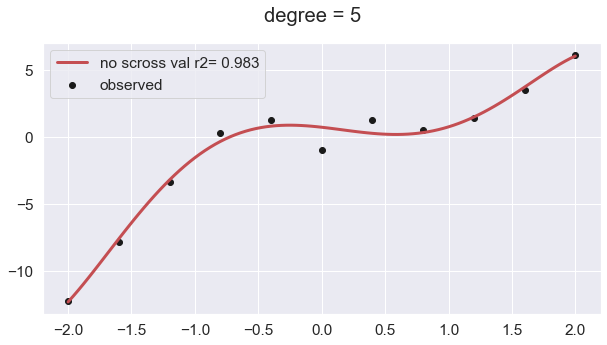

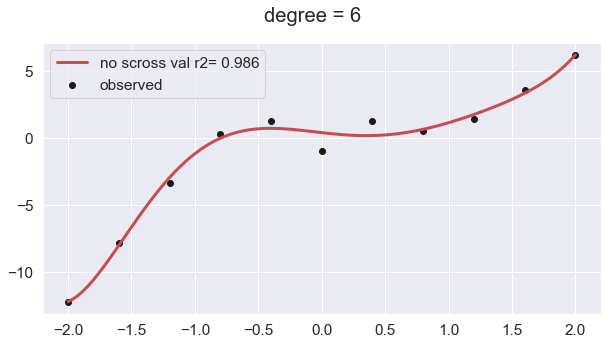

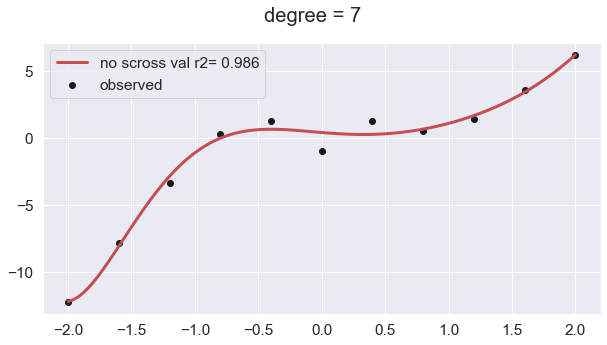

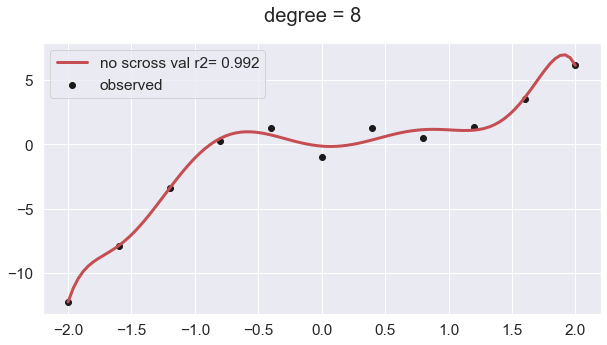

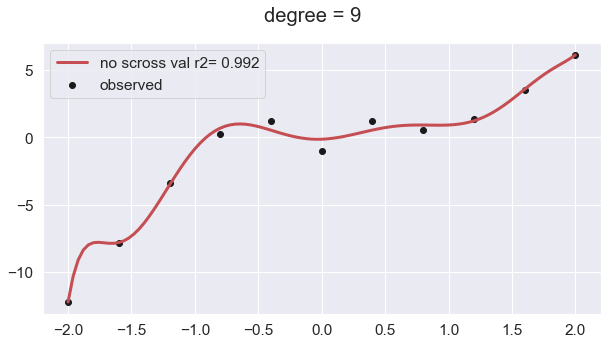

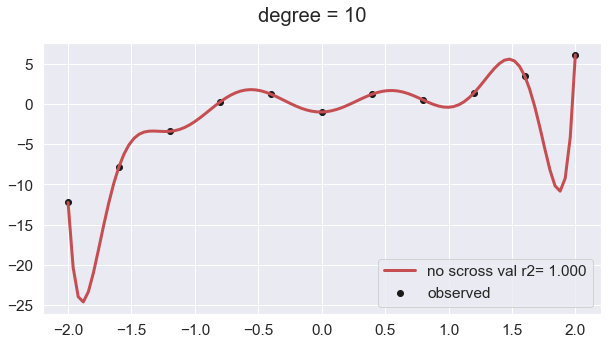

In [43]:
for degree in range(11):
    # figure for every degree
    plt.figure()
    
    fit_plot_poly(x, y, degree)
    plt.suptitle(f'degree = {degree}')
    plt.gcf().set_size_inches(10,5)

### Response
As the degree increases, the model becomes more flexible. The polynomial with the lowest r^2 is not the best model because r^2 is 0 and the model (line) does not fit good with the data as shown in degree 0 graph.